In [1]:
library(tidyverse)
library(igraph)

source('../utils/plottingUtilities.R')

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.0     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   1.0.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘igraph’


The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


The following objects are masked from ‘package:purrr’:

    compose, simplify


The following object is masked from ‘package:tidyr’:

    crossing


The following object is masked from ‘package:tibble’:

    as_data_frame


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union


Loading required package: scales


Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

  

In [2]:
# from this, we really just need late$template
load('../data/lateData.Rdata')

In [6]:
# load irf fits
load('../scripts/irf_fits_2020-04-13/irfSpatialFit_gut_set12pp_rmPdp1.Rdata')

In [7]:
ls()

[1] "fit"             "generateImage"   "getNodeImages"   "getNodeLabel"   
 [5] "getNodePosition" "img2Color"       "late"            "mapLate2Early"  
 [9] "multiplot"       "overlayImage"    "overlayImages"   "plot_all_PPs"   
[13] "plotGroupImg"    "plotImg"         "plotPP"          "shiftHoriz"     
[17] "shiftImg"        "shiftVert"       "test.id"         "tf"             
[21] "train.id"        "x.late"          "y.late"

# get interactions

In [8]:
interactions <- fit$interaction[, 1]

In [9]:
interactions

[1] "feo+_Ptx1+"       "CG1785+_Ptx1+"    "Idgf4+_Ptx1+"     "dm+_Ptx1+"       
 [5] "Ptx1+_Rapgap1+"   "Mes2+_Ptx1+"      "CG10267+_Ptx1+"   "cad+_CG9232+"    
 [9] "Ptx1+_Rtnl1+"     "larp+_Ptx1+"      "Ptx1+_Thor+"      "CG13900-_CG9232+"
[13] "Ptx1+_TMS1+"      "for2+_Ptx1-"      "Ptx1-_stwl+"      "CG10645-_CG9232+"
[17] "CG11076+_Ptx1+"   "CG10645-_Ptx1+"   "CG9232+_Klp3A-"   "CG10267-_CG9232+"
[21] "CG9232+_Ptx1-"    "cad+_CG9467+"     "exex+_Ptx1-"

In [10]:
# first gene
interaction1 <- gsub('[+, -]_.*', "", unlist(interactions))
print(interaction1)

sign1 <- substr(interactions,nchar(interaction1)+1,nchar(interaction1)+1)

 [1] "feo"     "CG1785"  "Idgf4"   "dm"      "Ptx1"    "Mes2"    "CG10267"
 [8] "cad"     "Ptx1"    "larp"    "Ptx1"    "CG13900" "Ptx1"    "for2"   
[15] "Ptx1"    "CG10645" "CG11076" "CG10645" "CG9232"  "CG10267" "CG9232" 
[22] "cad"     "exex"   


In [11]:
# second_gene
interaction2 <- gsub('.*[+, -]_', "", unlist(interactions))

sign2 <- substr(interaction2,nchar(interaction2),nchar(interaction2)) 

interaction2 <- substr(interaction2,1,nchar(interaction2)-1) 

In [12]:
interaction2

[1] "Ptx1"    "Ptx1"    "Ptx1"    "Ptx1"    "Rapgap1" "Ptx1"    "Ptx1"   
 [8] "CG9232"  "Rtnl1"   "Ptx1"    "Thor"    "CG9232"  "TMS1"    "Ptx1"   
[15] "stwl"    "CG9232"  "Ptx1"    "Ptx1"    "Klp3A"   "CG9232"  "Ptx1"   
[22] "CG9467"  "Ptx1"

In [13]:
# just check for my sanity regex logic is correct
all(interactions == paste0(interaction1, sign1, '_', interaction2, sign2))

[1] TRUE

# Plot a few interactoins

In [14]:
indx <- seq(1, 8)

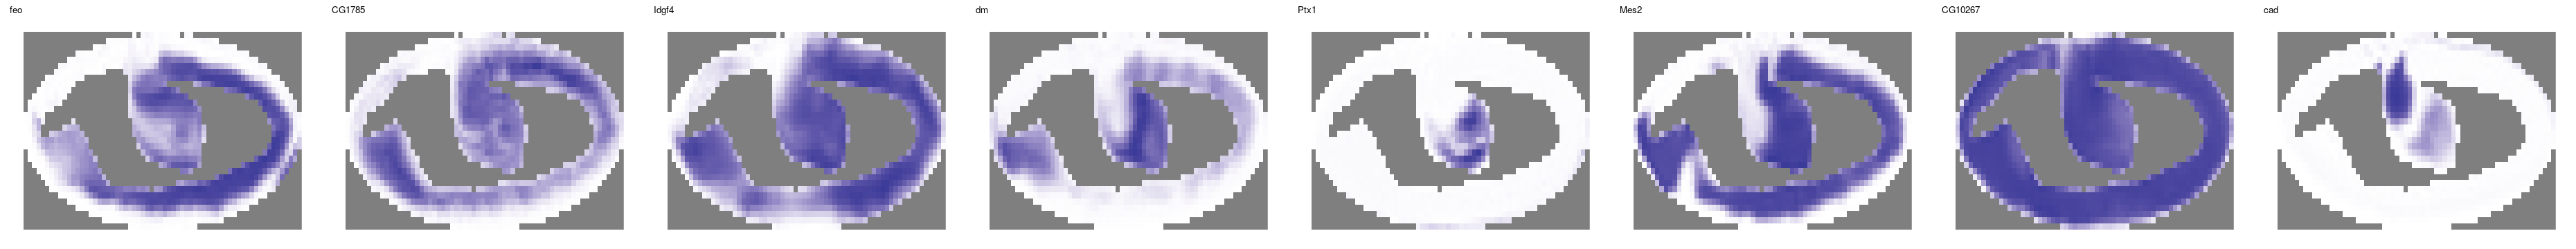

In [15]:
p <- list()

for(i in 1:length(indx)){
    gene <- interaction1[indx[i]]
    p[[i]] <- plotImg(x.late[, gene], late$template, FALSE, gene)       
}

options(repr.plot.width = 31, repr.plot.height = 3)
multiplot(plotlist = p, cols = length(indx))


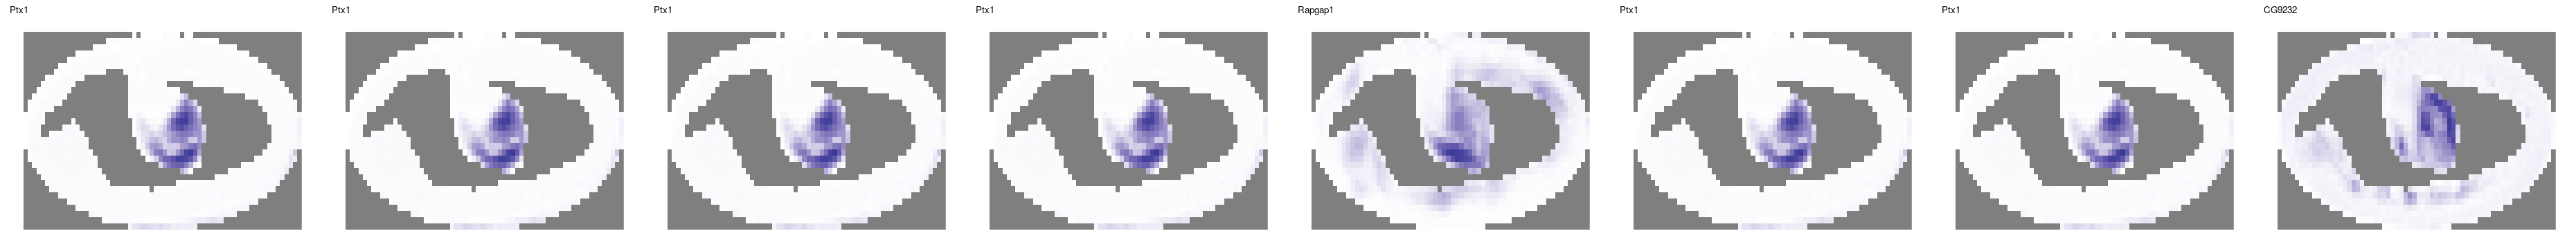

In [16]:
p <- list()

for(i in 1:length(indx)){
    gene <- interaction2[indx[i]]
    p[[i]] <- plotImg(x.late[, gene], late$template, FALSE, gene)       
}

options(repr.plot.width = 31, repr.plot.height = 3)
multiplot(plotlist = p, cols = length(indx))


In [17]:
interactions[indx]

[1] "feo+_Ptx1+"     "CG1785+_Ptx1+"  "Idgf4+_Ptx1+"   "dm+_Ptx1+"     
[5] "Ptx1+_Rapgap1+" "Mes2+_Ptx1+"    "CG10267+_Ptx1+" "cad+_CG9232+"

# Construct graph

In [18]:
unique.genes <- unique(c(interaction1, interaction2))

In [19]:
network.mat <- matrix(rep(0, length(unique.genes)**2), ncol = length(unique.genes))
colnames(network.mat) <- unique.genes
rownames(network.mat) <- unique.genes

In [20]:
stability.scores <- fit$interaction[, 'stability'] + 1e-6

In [21]:
edges <- rep(0, length(interaction1))
for(i in 1:length(interaction1)){
    gene1 <- interaction1[i]
    gene2 <- interaction2[i]
    
    if(sign1[i] == sign2[i]){
        network.mat[gene1, gene2] <- 1 * stability.scores[i]
        network.mat[gene2, gene1] <- 1 * stability.scores[i]
    }
    if(sign1[i] != sign2[i]){
        network.mat[gene1, gene2] <- -1 * stability.scores[i]
        network.mat[gene2, gene1] <- -1 * stability.scores[i]
    }
        
}

In [22]:
iRF.graph <- graph_from_adjacency_matrix(network.mat, weighted = TRUE,
                                   diag = FALSE, 
                                    mode = 'upper')


In [23]:
la <- layout_with_dh(iRF.graph)

In [24]:
E(iRF.graph)$color[E(iRF.graph)$weight > 0] <- 'red'
E(iRF.graph)$color[E(iRF.graph)$weight < 0] <- 'blue'

In [25]:
E(iRF.graph)$width <- abs(E(iRF.graph)$weight) * 10

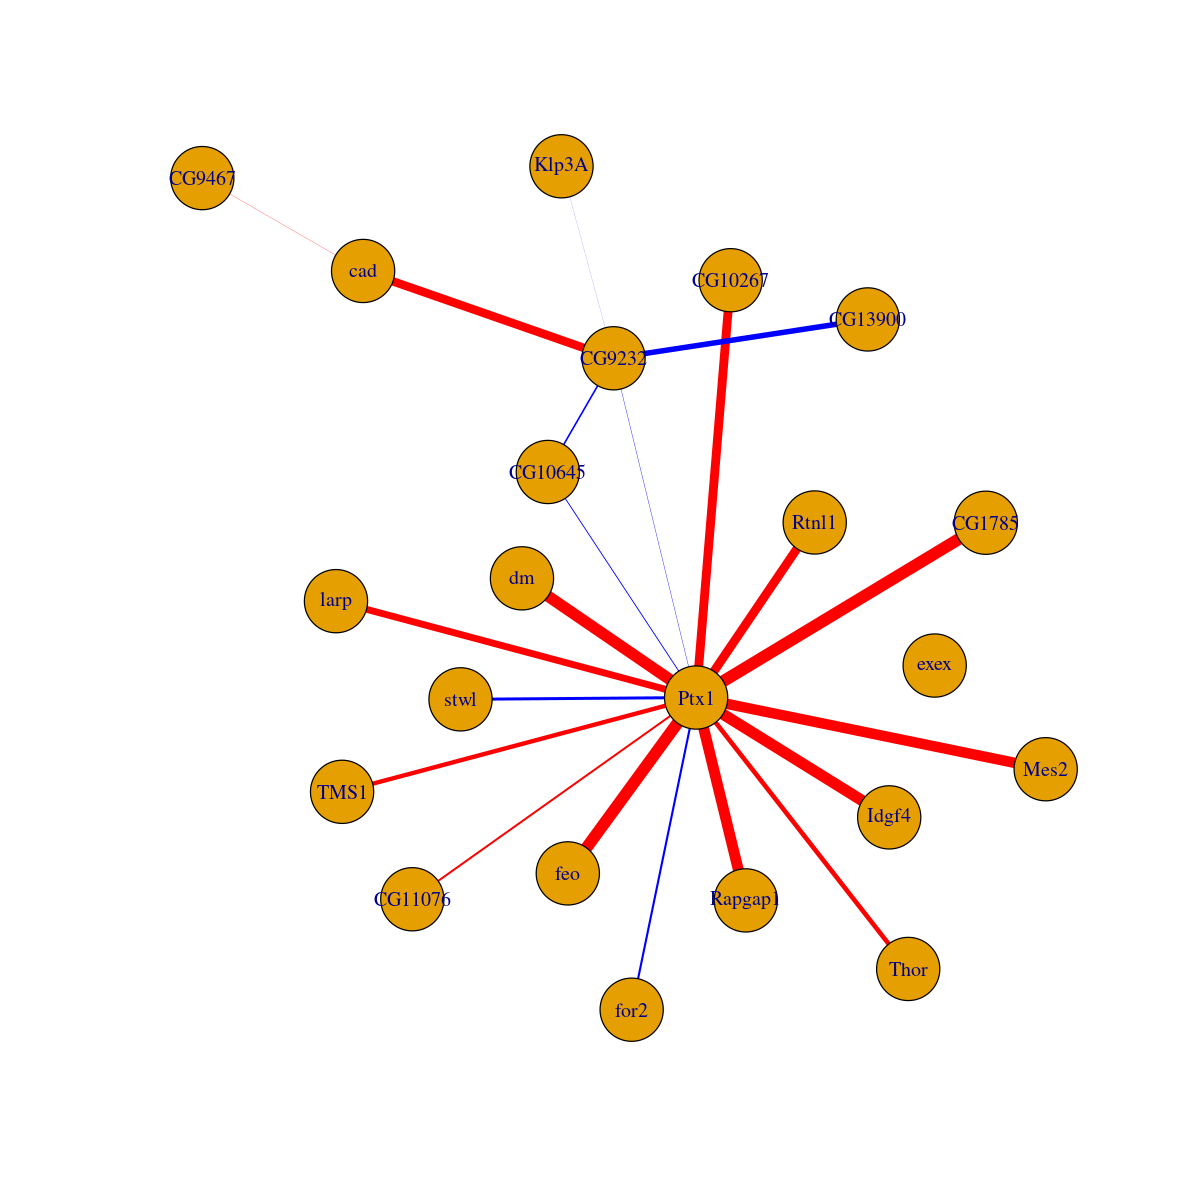

In [26]:
options(repr.plot.width = 10, repr.plot.height = 10)
plot(iRF.graph, layout = la, edge.width=E(iRF.graph)$width)

In [27]:
interactions

[1] "feo+_Ptx1+"       "CG1785+_Ptx1+"    "Idgf4+_Ptx1+"     "dm+_Ptx1+"       
 [5] "Ptx1+_Rapgap1+"   "Mes2+_Ptx1+"      "CG10267+_Ptx1+"   "cad+_CG9232+"    
 [9] "Ptx1+_Rtnl1+"     "larp+_Ptx1+"      "Ptx1+_Thor+"      "CG13900-_CG9232+"
[13] "Ptx1+_TMS1+"      "for2+_Ptx1-"      "Ptx1-_stwl+"      "CG10645-_CG9232+"
[17] "CG11076+_Ptx1+"   "CG10645-_Ptx1+"   "CG9232+_Klp3A-"   "CG10267-_CG9232+"
[21] "CG9232+_Ptx1-"    "cad+_CG9467+"     "exex+_Ptx1-"